In [126]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [5]:
# !for pid in `pgrep -f jupyter`; do { renice 5 $pid; }; done

11467 (process ID) old priority 0, new priority 5
34190 (process ID) old priority 0, new priority 5
37843 (process ID) old priority 0, new priority 5
38134 (process ID) old priority 0, new priority 5


In [2]:
# !for pid in `pgrep -f jupyter`; do { ps -u -p $pid; }; done

USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  11467  0.2  0.2 998688 223760 ?       SNl  Jun16  24:17 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  31582  0.6  0.2 865932 208852 ?       SNsl 11:25   0:10 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  34190  0.0  0.0 185772 49328 ?        SNl  Jun15   0:01 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  46753 41.0  0.0   4500   776 pts/35   SNs+ 11:52   0:00 /bin/sh -c for 


In [ ]:
# !stat -c '%y' OPTICS_shape16_moments4_max_eps4_min_samp500_euclidean_alldata.pkl
# 2020-06-22 01:46:51.500058368 +0100


# Load the model, which encodes series (128 data points long) into 16 latent components

In [4]:
weights_dir = "../../../model_weights/model_2020-08-30_11-42-38.h5"


class Sampling_func(layers.Layer):
    """Uses distribution parameters (z_mean, z_log_var) to sample latent variables z, the vector encoding a light curve segment.
    source:
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128 # input dimension
intermediate_dim = 1024 # number of LSTM cells
latent_dim = 16 # dimension of the latent code

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='Encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False, name="Encoder_LSTM")(original_inputs)
z_mean = layers.Dense(latent_dim, name='Latent_mean')(x)
z_log_var = layers.Dense(latent_dim, name='Latent_log_var')(x)
z = Sampling_func()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='Decoder_input')
x = layers.RepeatVector(original_dim, name="Expand_to_decoder_shape")(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True, name="Decoder_LSTM")(x)
outputs = layers.TimeDistributed(layers.Dense(1), name="Collapse_to_output_shape")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Combine the two to define the VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data (segments, and their uncertainties and IDs)

In [5]:
segments_dir = '{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir)
errors_dir = '{}/468202_len128_s2_4cad_errors_errorfix.pkl'.format(data_dir)
seg_ids_dir = "{}/468202_len128_s2_4cad_ids_errorfix.pkl".format(data_dir)

with open(segments_dir, 'rb') as f: # load shuffled light curve segments
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f: # load uncertainty values for the segments
    errors = pickle.load(f)
with open(seg_ids_dir, 'rb') as f: # IDs of the segments (observation id followed by segment index)
    seg_ids = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32) # scale the uncertainty
segments = zscore(segments, axis=1).astype(np.float32)  # standardize each segment independently

# Reconstruct the segments using the model

In [6]:
# for visualisation purposes, reconstruct only a few segments
try_first_x = 10 # how many segments to reconstruct
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    print("Done {}/{}".format(segment_index+1, try_first_x))
    clear_output(wait=True)
plot_index = np.copy(try_first_x)-1 # for use of the plotting cell below

Done 10/10


In [28]:
# save the reconstructions for later
segment_reconstructions_dir = '{}/reconstructions_from_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0])
# with open(segment_reconstructions_dir, 'wb') as f:
#     pickle.dump(reconstructions, f)

with open(segment_reconstructions_dir, 'rb') as f:
    reconstructions = pickle.load(f)

segment ID:  92702-01-16-00_161


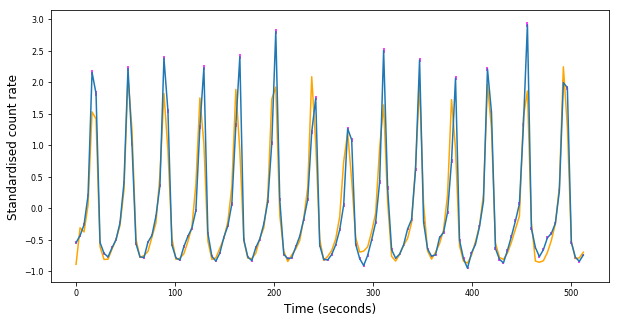

In [22]:
# plot the segments and reconstuctions
# run the cell repeteadly to loop through the segments

print("segment ID: ", seg_ids[plot_index])
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams.update({'font.size': 8})
plt.errorbar(np.linspace(0,512, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,512, 128), reconstructions[plot_index], color="orange")
plt.ylabel("Standardised count rate", fontsize=12)
plt.xlabel("Time (seconds)", fontsize=12)
plt.show()
if plot_index>0:
    plot_index-=1
else:
    plot_index = np.copy(try_first_x)-1

In [80]:
seg_ids[-2]

'50405-01-04-00_136'

# Encode the data set using the model

In [34]:
# Run the segments through the encoder and find latent means and log variances

encode_first = segments.shape[0]

trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("Latent_mean").output, vae.get_layer("Latent_log_var").output])
segment_encoding = np.zeros((encode_first, 2, 16))
for seg_ind, seg in enumerate(segments[:encode_first]):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print("Done {}/{}".format(seg_ind, encode_first))
    clear_output(wait=True)
    

468201


In [125]:
# save the code for later

segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
# with open(segment_encoding_dir, 'wb') as f:
#     pickle.dump(segment_encoding, f)
print("Encodings saved to: ", segment_encoding_dir)

with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

Encodings saved to:  ../../../data_GRS1915/segment_encoding_model_2020-08-30_11-42-38_segments_468202_len128_s2_4cad_counts_errorfix.pkl


# Traverse the latent space along its axes 

In [228]:
n

17

segment ID:  96378-01-01-02_209


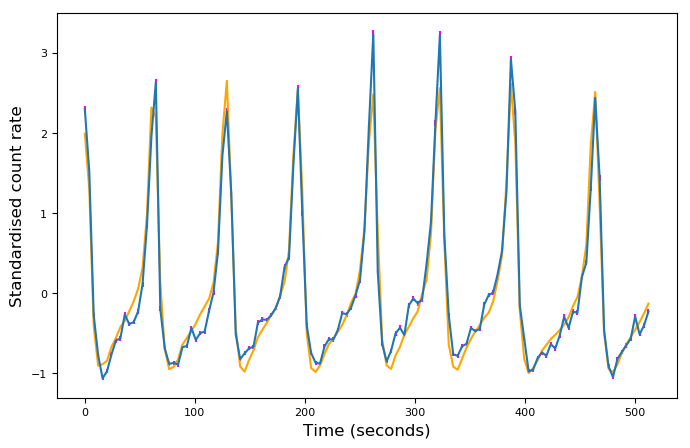

In [297]:
probe_segment_index = -7

print("segment ID: ", seg_ids[probe_segment_index])
plt.rcParams['figure.figsize'] = (8.0, 5.0)
plt.rcParams.update({'font.size': 8})
plt.errorbar(np.linspace(0,512, 128), segments[probe_segment_index], yerr=errors[probe_segment_index], ecolor="magenta")
plt.plot(np.linspace(0,512, 128), reconstructions[probe_segment_index], color="orange")
plt.ylabel("Standardised count rate", fontsize=12)
plt.xlabel("Time (seconds)", fontsize=12)
plt.show()


In [298]:
traversal = np.zeros((16,11,128))
for variable in range(16):
    for step_ind, step in enumerate(np.linspace(-10,10, num=11)):
        probe_code = deepcopy(segment_encoding[probe_segment_index, 0, :])
        probe_code[variable] +=step
        traversal[variable, step_ind, :] = decoder.predict(np.expand_dims(probe_code, axis=0)).flatten()
        print("{}/16, {}/11".format(variable+1, step_ind+1))
        clear_output(wait=True)

16/16, 11/11


In [248]:
n

13

In [300]:
n=0

In [317]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
for step_ind, step in enumerate(np.linspace(-10,10, num=10)):
    if step_ind == 5:
        linewidth=3
    else:
        linewidth=1
    plt.plot(traversal[n,step_ind,:]+3*step_ind, linewidth=linewidth)
plt.show()
n+=1

IndexError: index 16 is out of bounds for axis 0 with size 16

In [30]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
Expand_to_decoder_shape (Rep (None, 128, 16)           0         
_________________________________________________________________
Decoder_LSTM (CuDNNLSTM)     (None, 128, 1024)         4268032   
_________________________________________________________________
Collapse_to_output_shape (Ti (None, 128, 1)            1025      
Total params: 4,269,057
Trainable params: 4,269,057
Non-trainable params: 0
_________________________________________________________________


0 -1.177073550060666 2.6673107558755786 -8.135400772094727 4.948286056518555


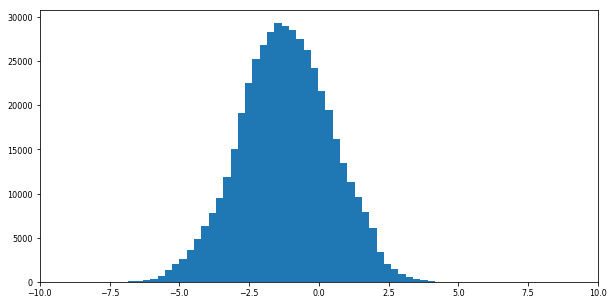

1 0.4653610726129919 1.2487602860438958 -5.082788944244385 5.3979926109313965


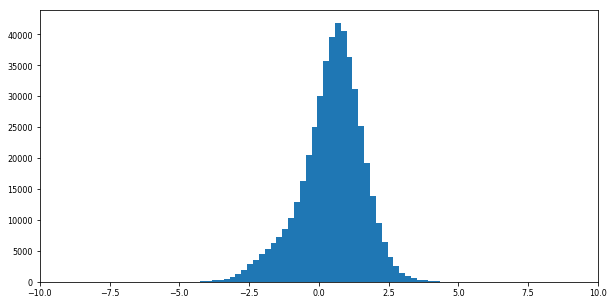

2 -0.8292641597552806 2.34855701771176 -7.576048374176025 5.920456409454346


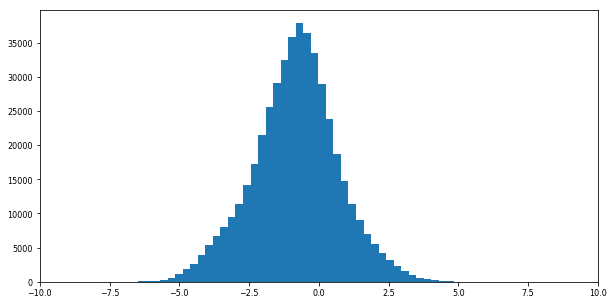

3 -0.3141868548479149 2.6599065703578715 -6.648402690887451 7.987971305847168


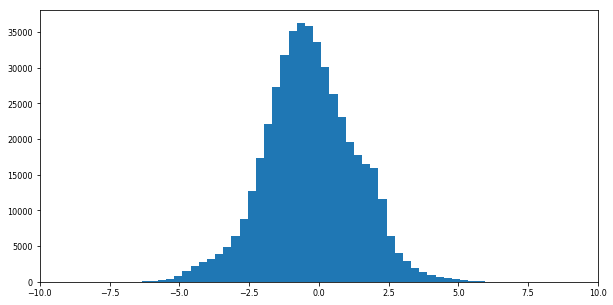

4 -0.018574348767022974 1.9079708773855528 -6.647986888885498 6.7302327156066895


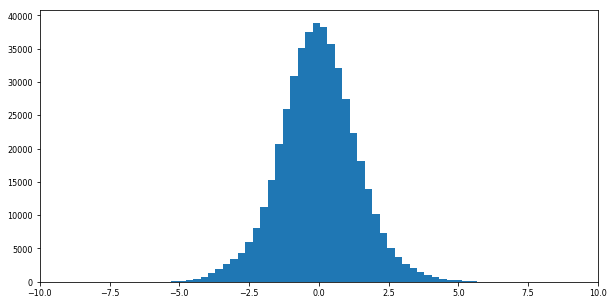

5 -1.5833653595632657 2.5467736168124326 -9.194974899291992 3.6911582946777344


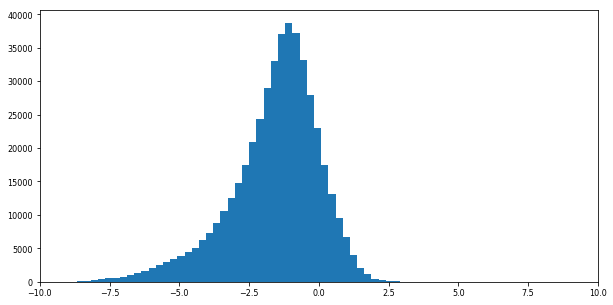

6 -1.610235334526248 1.891618794843918 -6.751436233520508 5.98721981048584


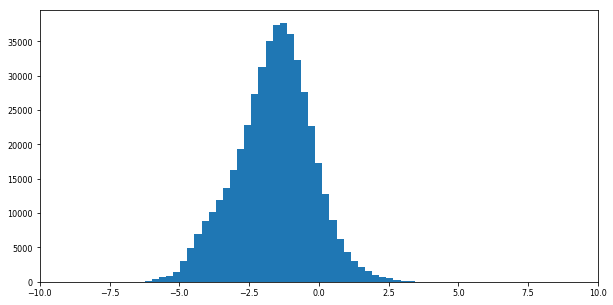

7 0.2941215556538696 1.4708121055198031 -5.3706793785095215 5.9974565505981445


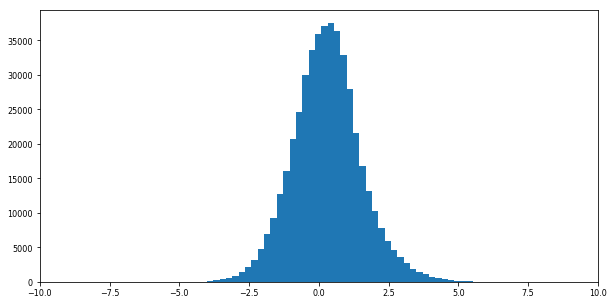

8 -0.20410265543824904 1.6174821294232136 -6.981325149536133 5.919382572174072


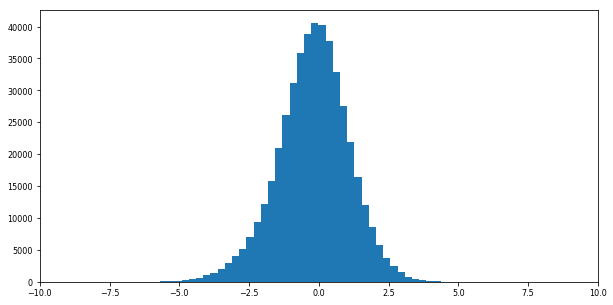

9 -0.007676527789865315 2.980175237483629 -6.541958808898926 6.6116108894348145


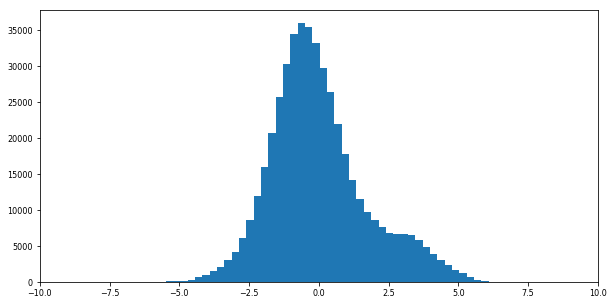

10 -0.35305872895718826 1.5671435369262212 -6.420745849609375 5.24638557434082


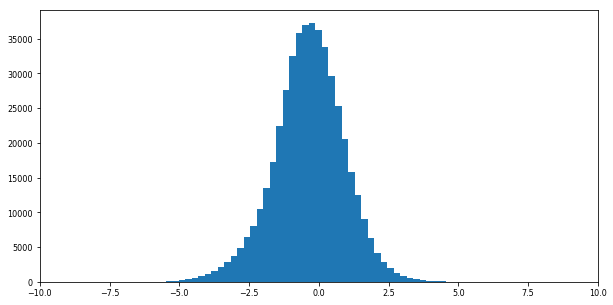

11 -1.1485397476018837 3.2182317176631487 -8.62534236907959 4.387147903442383


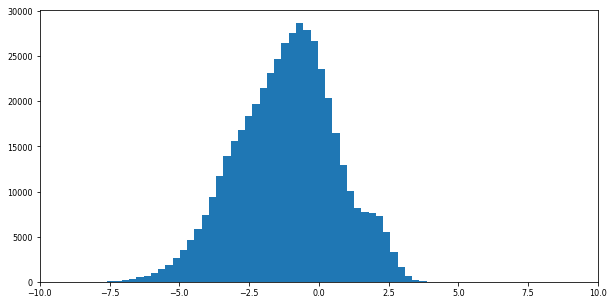

12 0.681881122985539 2.3422175920857033 -6.610356330871582 7.803376197814941


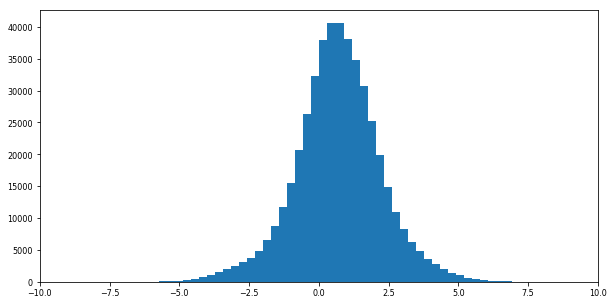

13 1.3061238181701993 1.571109658374122 -3.8258752822875977 7.768794059753418


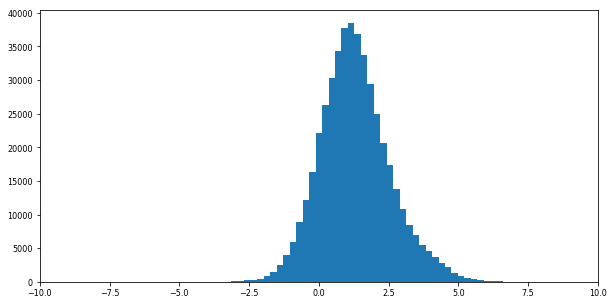

14 0.665311323512705 1.9725592097084839 -5.244612216949463 8.6033935546875


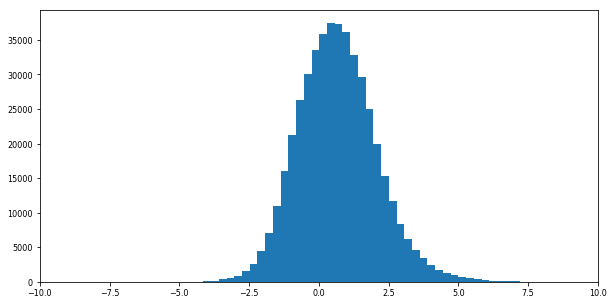

15 0.1481565271012916 1.6403875841074091 -5.821347236633301 6.246656894683838


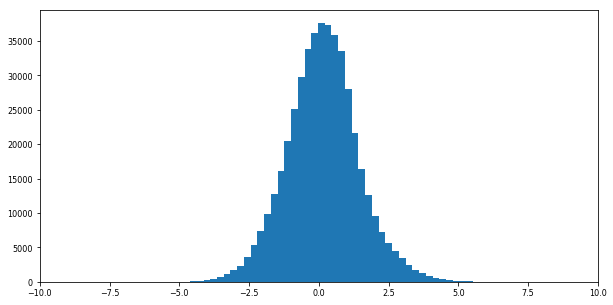

In [25]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

for latent_var in range(16):
    plt.hist(segment_encoding[:,0,latent_var], bins=50)
    print(latent_var, np.mean(segment_encoding[:,0,latent_var]), np.var(segment_encoding[:,0,latent_var]), np.min(segment_encoding[:,0,latent_var]), np.max(segment_encoding[:,0,latent_var]))
    plt.xlim([-10,10])
    plt.show()

In [65]:
segment_encoding.shape

(468202, 2, 16)

In [63]:
reconstructions

array([[-1.00525534, -1.11903822, -1.0929575 , ...,  2.31782794,
         2.33014846,  2.28626704],
       [-0.30332881, -0.48582447, -0.62074888, ...,  0.23847777,
         0.15714717,  0.09173238],
       [ 0.54193729,  0.81692976,  0.87194377, ..., -0.26292771,
        -0.51480538, -0.60396343],
       ...,
       [ 1.17675591,  0.84115833,  0.5056569 , ...,  0.10502428,
         0.2016235 ,  0.19304341],
       [-0.70324725, -0.83255589, -0.71789157, ..., -0.3790791 ,
        -1.10834169, -1.12942874],
       [-0.77766663, -0.99768722, -0.96848094, ...,  1.77506042,
         1.69204116,  1.57516217]])